# Download Dataset & Extract Zip File

In [1]:
# COCO Dataset 다운로드

import urllib
import zipfile
from tqdm import tqdm

#https://stackoverflow.com/a/53877507/1558946
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_data(url):
    print(f"{url} 다운로드 중 ...")
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        zip_path, _ = urllib.request.urlretrieve(url, reporthook=t.update_to)

    print("압축을 푸는 중 ...")
    with zipfile.ZipFile(zip_path, "r") as f:
        for name in tqdm(iterable=f.namelist(), total=len(f.namelist())):
            f.extract(member=name, path="data_dir")


download_data("http://images.cocodataset.org/annotations/annotations_trainval2014.zip")
download_data("http://images.cocodataset.org/zips/train2014.zip")
download_data("http://images.cocodataset.org/zips/val2014.zip")

http://images.cocodataset.org/annotations/annotations_trainval2014.zip 다운로드 중 ...


annotations_trainval2014.zip: 253MB [00:16, 14.9MB/s]                           


압축을 푸는 중 ...


100%|██████████| 6/6 [00:06<00:00,  1.02s/it]


http://images.cocodataset.org/zips/train2014.zip 다운로드 중 ...


train2014.zip: 13.5GB [15:15, 14.8MB/s]                            


압축을 푸는 중 ...


100%|██████████| 82784/82784 [01:49<00:00, 753.60it/s]


http://images.cocodataset.org/zips/val2014.zip 다운로드 중 ...


val2014.zip: 6.65GB [07:05, 15.6MB/s]                            


압축을 푸는 중 ...


100%|██████████| 40505/40505 [00:53<00:00, 750.43it/s]


# Preprocessing

## Text (Caption) Data

In [2]:
import os
import nltk
import pickle
import numpy as np
from PIL import Image
from collections import Counter
from pycocotools.coco import COCO
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.utils.data as data
from torchvision import transforms
import torchvision.models as models
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pack_padded_sequence

In [3]:
# punkt tokenizer 모델을 통해 주어진 텍스트를 구성된 단어로 토큰화
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [4]:
class Vocab(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.w2i = {}
        self.i2w = {}
        self.index = 0

    def __call__(self, token):
        if not token in self.w2i:
            return self.w2i['<unk>']
        return self.w2i[token]

    def __len__(self):
        return len(self.w2i)
    def add_token(self, token):
        if not token in self.w2i:
            self.w2i[token] = self.index
            self.i2w[self.index] = token
            self.index += 1

In [5]:
# 실제 텍스트 토큰(단어 등)을 숫자 토큰으로 전환할 수 있는 사전 구축
def build_vocabulary(json, threshold):
    """Build a simple vocabulary wrapper."""
    # Load JSON Text Annotation
    coco = COCO(json)
    counter = Counter()
    ids = coco.anns.keys()
    for i, id in enumerate(ids):
        # Tokenize each word in Annotation/Caption (Convert to numbers) and Save to Counter
        caption = str(coco.anns[id]['caption'])
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        counter.update(tokens)

        if (i+1) % 100000 == 0:
            print("[{}/{}] Tokenized the captions.".format(i+1, len(ids)))

    # If the word frequency is less than 'threshold', then the word is discarded.
    tokens = [token for token, cnt in counter.items() if cnt >= threshold]

    # Create a vocab wrapper and add some special tokens.
    vocab = Vocab()
    vocab.add_token('<pad>')
    vocab.add_token('<start>')
    vocab.add_token('<end>')
    vocab.add_token('<unk>')

    # Add the words to the vocabulary.
    for i, token in enumerate(tokens):
        vocab.add_token(token)
    return vocab

vocab = build_vocabulary(json='data_dir/annotations/captions_train2014.json', threshold=4)
vocab_path = './data_dir/vocabulary.pkl'
with open(vocab_path, 'wb') as f:
    pickle.dump(vocab, f)
print("Total vocabulary size: {}".format(len(vocab)))
print("Saved the vocabulary wrapper to '{}'".format(vocab_path))

loading annotations into memory...
Done (t=0.97s)
creating index...
index created!
[100000/414113] Tokenized the captions.
[200000/414113] Tokenized the captions.
[300000/414113] Tokenized the captions.
[400000/414113] Tokenized the captions.
Total vocabulary size: 9948
Saved the vocabulary wrapper to './data_dir/vocabulary.pkl'


## Image Data

In [6]:
# 고정된 image_shape로 reshape
def reshape_image(image, shape):
    """Resize an image to the given shape."""
    # return image.resize(shape, Image.ANTIALIAS) # Pillow 10.0.0에서 'ANTIALIAS'의 모듈이 제거되었음
    return image.resize(shape, Image.LANCZOS)

def reshape_images(image_path, output_path, shape):
    """Reshape the images in 'image_path' and save into 'output_path'."""
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    images = os.listdir(image_path)
    num_im = len(images)
    for i, im in enumerate(images):
        with open(os.path.join(image_path, im), 'r+b') as f:
            with Image.open(f) as image:
                image = reshape_image(image, shape)
                image.save(os.path.join(output_path, im), image.format)
        if (i+1) % 10000 == 0:
            print ("[{}/{}] Resized the images and saved into '{}'."
                   .format(i+1, num_im, output_path))

image_path = './data_dir/train2014/'
output_path = './data_dir/resized_images/'
image_shape = [256, 256]
reshape_images(image_path, output_path, image_shape)

[10000/82783] Resized the images and saved into './data_dir/resized_images/'.
[20000/82783] Resized the images and saved into './data_dir/resized_images/'.
[30000/82783] Resized the images and saved into './data_dir/resized_images/'.
[40000/82783] Resized the images and saved into './data_dir/resized_images/'.
[50000/82783] Resized the images and saved into './data_dir/resized_images/'.
[60000/82783] Resized the images and saved into './data_dir/resized_images/'.
[70000/82783] Resized the images and saved into './data_dir/resized_images/'.
[80000/82783] Resized the images and saved into './data_dir/resized_images/'.


# Define Image Caption Data Loader

In [7]:
class CustomCocoDataset(data.Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self, data_path, coco_json_path, vocabulary, transform=None):
        """Set the path for images, captions and vocabulary wrapper.

        Args:
            root: image directory.
            json: coco annotation file path.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """
        self.root = data_path
        self.coco_data = COCO(coco_json_path)
        self.indices = list(self.coco_data.anns.keys())
        self.vocabulary = vocabulary
        self.transform = transform

    def __getitem__(self, idx):
        """Returns one data pair (image and caption)."""
        coco_data = self.coco_data
        vocabulary = self.vocabulary
        annotation_id = self.indices[idx]
        caption = coco_data.anns[annotation_id]['caption']
        image_id = coco_data.anns[annotation_id]['image_id']
        image_path = coco_data.loadImgs(image_id)[0]['file_name']

        image = Image.open(os.path.join(self.root, image_path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        # Convert caption (string) to word ids.
        word_tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocabulary('<start>'))
        caption.extend([vocabulary(token) for token in word_tokens])
        caption.append(vocabulary('<end>'))
        ground_truth = torch.Tensor(caption)
        return image, ground_truth

    def __len__(self):
        return len(self.indices)

In [8]:
def collate_function(data_batch):
    """Creates mini-batch tensors from the list of tuples (image, caption).

    We should build custom collate_fn rather than using default collate_fn,
    because merging caption (including padding) is not supported in default.
    Args:
        data: list of tuple (image, caption).
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length (descending order).
    data_batch.sort(key=lambda d: len(d[1]), reverse=True)
    imgs, caps = zip(*data_batch)

    # Merge images (from list of 3D tensors to 4D tensor).
    # Originally, imgs is a list of <batch_size> number of RGB images with dimensions (3, 256, 256)
    # This line of code turns it into a single tensor of dimensions (<batch_size>, 3, 256, 256)
    imgs = torch.stack(imgs, 0)

    # Merge captions (from list of 1D tensors to 2D tensor), similar to merging of images donw above.
    cap_lens = [len(cap) for cap in caps]
    tgts = torch.zeros(len(caps), max(cap_lens)).long()
    for i, cap in enumerate(caps):
        end = cap_lens[i]
        tgts[i, :end] = cap[:end]
    return imgs, tgts, cap_lens

In [9]:
# COCO Dataset을 위한 맞춤형 데이터 로더를 반환하는 get_loader 함수 구현
def get_loader(data_path, coco_json_path, vocabulary, transform, batch_size, shuffle, num_workers):
    """Returns torch.utils.data.DataLoader for custom coco dataset."""
    # COCO caption dataset
    coco_dataset = CustomCocoDataset(data_path=data_path,
                       coco_json_path=coco_json_path,
                       vocabulary=vocabulary,
                       transform=transform)

    # Data loader for COCO dataset
    # This will return (images, captions, lengths) for each iteration.
    # images: a tensor of shape (batch_size, 3, 224, 224).
    # captions: a tensor of shape (batch_size, padded_length).
    # lengths: a list indicating valid length for each caption. length is (batch_size).
    custom_data_loader = torch.utils.data.DataLoader(dataset=coco_dataset,
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=num_workers,
                                              collate_fn=collate_function)
    return custom_data_loader

# Define Models

## CNN

In [10]:
class CNNModel(nn.Module):
    def __init__(self, embedding_size):
        """Load the pretrained efficientnet and replace top fc layer."""
        super(CNNModel, self).__init__()
        efficientnet = models.efficientnet_b4(weights='IMAGENET1K_V1')
        module_list = list(efficientnet.children())[:-1]      # delete the last dropout & fc layer.
        last_layer = list(efficientnet.children())[-1]      # fc layer of efficientnet = list(efficientnet.children())[-1]
        self.efficientnet_module = nn.Sequential(*module_list, last_layer[0]) # add the pretrained last dropout layer.
        self.linear_layer = nn.Linear(last_layer[1].in_features, embedding_size)
        self.batch_norm = nn.BatchNorm1d(embedding_size, momentum=0.01)

    def forward(self, input_images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            efficientnet_features = self.efficientnet_module(input_images)
        efficientnet_features = efficientnet_features.reshape(efficientnet_features.size(0), -1)
        final_features = self.batch_norm(self.linear_layer(efficientnet_features))
        return final_features

## LSTM

In [11]:
class LSTMModel(nn.Module):
    def __init__(self, embedding_size, hidden_layer_size, vocabulary_size, num_layers, max_seq_len=20):
        """Set the hyper-parameters and build the layers."""
        super(LSTMModel, self).__init__()
        self.embedding_layer = nn.Embedding(vocabulary_size, embedding_size)
        self.lstm_layer = nn.LSTM(embedding_size, hidden_layer_size, num_layers, batch_first=True)
        self.linear_layer = nn.Linear(hidden_layer_size, vocabulary_size)
        self.max_seq_len = max_seq_len

    def forward(self, input_features, capts, lens):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embedding_layer(capts)
        embeddings = torch.cat((input_features.unsqueeze(1), embeddings), 1)
        lstm_input = pack_padded_sequence(embeddings, lens, batch_first=True)
        hidden_variables, _ = self.lstm_layer(lstm_input)
        model_outputs = self.linear_layer(hidden_variables[0])
        return model_outputs

    def sample(self, input_features, lstm_states=None):
        """Generate captions for given image features using greedy search."""
        sampled_indices = []
        lstm_inputs = input_features.unsqueeze(1)
        for i in range(self.max_seq_len):
            hidden_variables, lstm_states = self.lstm_layer(lstm_inputs, lstm_states)          # hiddens: (batch_size, 1, hidden_size)
            model_outputs = self.linear_layer(hidden_variables.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted_outputs = model_outputs.max(1)                        # predicted: (batch_size)
            sampled_indices.append(predicted_outputs)
            lstm_inputs = self.embedding_layer(predicted_outputs)                       # inputs: (batch_size, embed_size)
            lstm_inputs = lstm_inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_indices = torch.stack(sampled_indices, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_indices

# Training

In [14]:
# set batch size
batch_size = 256

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if not os.path.exists('models_dir/'):
    os.makedirs('models_dir/')

# Image preprocessing, normalization for the pretrained resnet
transform = transforms.Compose([
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))])


# Load vocabulary wrapper
with open('data_dir/vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)

# Build data loader
custom_data_loader = get_loader('data_dir/resized_images', 'data_dir/annotations/captions_train2014.json', vocabulary,
                         transform, batch_size,
                         shuffle=True, num_workers=0)

# Build the models
encoder_model = CNNModel(256).to(device)
decoder_model = LSTMModel(256, 512, len(vocabulary), 1).to(device)


# Loss and optimizer
loss_criterion = nn.CrossEntropyLoss()
parameters = list(decoder_model.parameters()) + list(encoder_model.linear_layer.parameters()) + list(encoder_model.batch_norm.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.001)


# Train the models
total_num_steps = len(custom_data_loader)

for epoch in range(5):
    for i, (imgs, caps, lens) in enumerate(tqdm(custom_data_loader)):

        # Set mini-batch dataset
        imgs = imgs.to(device)
        caps = caps.to(device)
        tgts = pack_padded_sequence(caps, lens, batch_first=True)[0]

        # Forward, backward and optimize
        feats = encoder_model(imgs)
        outputs = decoder_model(feats, caps, lens)
        loss = loss_criterion(outputs, tgts)
        decoder_model.zero_grad()
        encoder_model.zero_grad()
        loss.backward()
        optimizer.step()

        # Print log info
        if i % 300 == 0 or i == total_num_steps - 1:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                  .format(epoch, 5, i, total_num_steps, loss.item(),
                          np.exp(loss.item())))

        # Save the model checkpoints
        if (i+1) % 1000 == 0:
            torch.save(decoder_model.state_dict(), os.path.join(
                'models_dir/', 'decoder-{}-{}.ckpt'.format(epoch+1, i+1)))
            torch.save(encoder_model.state_dict(), os.path.join(
                'models_dir/', 'encoder-{}-{}.ckpt'.format(epoch+1, i+1)))

loading annotations into memory...
Done (t=0.59s)
creating index...
index created!


  0%|          | 1/1618 [00:02<1:15:07,  2.79s/it]

Epoch [0/5], Step [0/1618], Loss: 9.2092, Perplexity: 9989.0972


 19%|█▊        | 301/1618 [05:32<31:21,  1.43s/it]

Epoch [0/5], Step [300/1618], Loss: 3.0993, Perplexity: 22.1835


 37%|███▋      | 601/1618 [11:06<24:14,  1.43s/it]

Epoch [0/5], Step [600/1618], Loss: 2.7600, Perplexity: 15.7996


 56%|█████▌    | 901/1618 [16:40<16:57,  1.42s/it]

Epoch [0/5], Step [900/1618], Loss: 2.6428, Perplexity: 14.0528


 74%|███████▍  | 1201/1618 [22:17<09:55,  1.43s/it]

Epoch [0/5], Step [1200/1618], Loss: 2.5807, Perplexity: 13.2063


 93%|█████████▎| 1501/1618 [27:51<02:47,  1.43s/it]

Epoch [0/5], Step [1500/1618], Loss: 2.4611, Perplexity: 11.7173


100%|██████████| 1618/1618 [30:01<00:00,  1.11s/it]


Epoch [0/5], Step [1617/1618], Loss: 2.3911, Perplexity: 10.9256


  0%|          | 1/1618 [00:01<47:18,  1.76s/it]

Epoch [1/5], Step [0/1618], Loss: 2.3953, Perplexity: 10.9712


 19%|█▊        | 301/1618 [05:36<31:19,  1.43s/it]

Epoch [1/5], Step [300/1618], Loss: 2.3838, Perplexity: 10.8457


 37%|███▋      | 601/1618 [11:10<24:06,  1.42s/it]

Epoch [1/5], Step [600/1618], Loss: 2.1771, Perplexity: 8.8203


 56%|█████▌    | 901/1618 [16:45<16:57,  1.42s/it]

Epoch [1/5], Step [900/1618], Loss: 2.3973, Perplexity: 10.9938


 74%|███████▍  | 1201/1618 [22:20<09:57,  1.43s/it]

Epoch [1/5], Step [1200/1618], Loss: 2.2675, Perplexity: 9.6549


 93%|█████████▎| 1501/1618 [27:54<02:47,  1.43s/it]

Epoch [1/5], Step [1500/1618], Loss: 2.2308, Perplexity: 9.3076


100%|██████████| 1618/1618 [30:05<00:00,  1.12s/it]


Epoch [1/5], Step [1617/1618], Loss: 2.2703, Perplexity: 9.6818


  0%|          | 1/1618 [00:01<47:26,  1.76s/it]

Epoch [2/5], Step [0/1618], Loss: 2.2252, Perplexity: 9.2555


 19%|█▊        | 301/1618 [05:36<31:19,  1.43s/it]

Epoch [2/5], Step [300/1618], Loss: 2.1504, Perplexity: 8.5884


 37%|███▋      | 601/1618 [11:11<24:12,  1.43s/it]

Epoch [2/5], Step [600/1618], Loss: 2.1978, Perplexity: 9.0052


 56%|█████▌    | 901/1618 [16:46<17:03,  1.43s/it]

Epoch [2/5], Step [900/1618], Loss: 2.1529, Perplexity: 8.6098


 74%|███████▍  | 1201/1618 [22:22<09:54,  1.43s/it]

Epoch [2/5], Step [1200/1618], Loss: 2.1040, Perplexity: 8.1987


 93%|█████████▎| 1501/1618 [27:57<02:47,  1.43s/it]

Epoch [2/5], Step [1500/1618], Loss: 2.2931, Perplexity: 9.9060


100%|██████████| 1618/1618 [30:11<00:00,  1.12s/it]


Epoch [2/5], Step [1617/1618], Loss: 2.1110, Perplexity: 8.2564


  0%|          | 1/1618 [00:01<46:16,  1.72s/it]

Epoch [3/5], Step [0/1618], Loss: 2.0427, Perplexity: 7.7113


 19%|█▊        | 301/1618 [05:41<31:18,  1.43s/it]

Epoch [3/5], Step [300/1618], Loss: 2.0408, Perplexity: 7.6968


 37%|███▋      | 601/1618 [11:18<24:10,  1.43s/it]

Epoch [3/5], Step [600/1618], Loss: 2.0721, Perplexity: 7.9417


 56%|█████▌    | 901/1618 [16:53<17:10,  1.44s/it]

Epoch [3/5], Step [900/1618], Loss: 2.1003, Perplexity: 8.1683


 74%|███████▍  | 1201/1618 [22:29<09:55,  1.43s/it]

Epoch [3/5], Step [1200/1618], Loss: 2.1847, Perplexity: 8.8883


 93%|█████████▎| 1501/1618 [28:04<02:46,  1.42s/it]

Epoch [3/5], Step [1500/1618], Loss: 1.9784, Perplexity: 7.2312


100%|██████████| 1618/1618 [30:15<00:00,  1.12s/it]


Epoch [3/5], Step [1617/1618], Loss: 1.9921, Perplexity: 7.3309


  0%|          | 1/1618 [00:02<55:11,  2.05s/it]

Epoch [4/5], Step [0/1618], Loss: 1.8951, Perplexity: 6.6530


 19%|█▊        | 301/1618 [05:37<31:19,  1.43s/it]

Epoch [4/5], Step [300/1618], Loss: 1.9081, Perplexity: 6.7404


 37%|███▋      | 601/1618 [11:12<24:01,  1.42s/it]

Epoch [4/5], Step [600/1618], Loss: 2.0178, Perplexity: 7.5218


 56%|█████▌    | 901/1618 [16:47<17:03,  1.43s/it]

Epoch [4/5], Step [900/1618], Loss: 1.9637, Perplexity: 7.1257


 74%|███████▍  | 1201/1618 [22:23<09:55,  1.43s/it]

Epoch [4/5], Step [1200/1618], Loss: 2.0561, Perplexity: 7.8157


 93%|█████████▎| 1501/1618 [28:02<02:46,  1.42s/it]

Epoch [4/5], Step [1500/1618], Loss: 2.0236, Perplexity: 7.5656


100%|██████████| 1618/1618 [30:13<00:00,  1.12s/it]

Epoch [4/5], Step [1617/1618], Loss: 1.9337, Perplexity: 6.9149


In [15]:
if not os.path.exists('results_dir'):
    os.makedirs('results_dir')
torch.save(decoder_model.state_dict(), os.path.join('results_dir', 'decoder.pt'))
torch.save(encoder_model.state_dict(), os.path.join('results_dir', 'encoder.pt'))

<start> a dog running on the beach with a frisbee . <end>


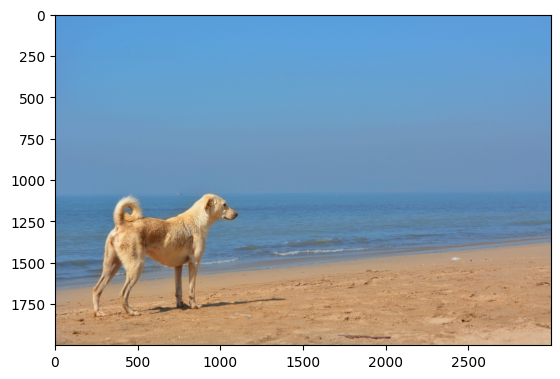

In [24]:
image_file_path = 'images3.jpg'

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def load_image(image_file_path, transform=None):
    img = Image.open(image_file_path).convert('RGB')
    img = img.resize([224, 224], Image.LANCZOS)

    if transform is not None:
        img = transform(img).unsqueeze(0)

    return img


# Image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))])


# Load vocabulary wrapper
with open('data_dir/vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)


# Build models
encoder = CNNModel(256).eval()  # eval mode (batchnorm uses moving mean/variance)
decoder = LSTMModel(256, 512, len(vocabulary), 1)
encoder = encoder.to(device)
decoder = decoder.to(device)


# Load the trained model parameters
encoder.load_state_dict(torch.load('results_dir/encoder.pt', weights_only=True))
decoder.load_state_dict(torch.load('results_dir/decoder.pt', weights_only=True))

# Prepare an image
img = load_image(image_file_path, transform)
img_tensor = img.to(device)


# Generate an caption from the image
feat = encoder(img_tensor)
sampled_indices = decoder.sample(feat)
sampled_indices = sampled_indices[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)


# Convert word_ids to words
predicted_caption = []
for token_index in sampled_indices:
    word = vocabulary.i2w[token_index]
    predicted_caption.append(word)
    if word == '<end>':
        break
predicted_sentence = ' '.join(predicted_caption)


# Print out the image and the generated caption
%matplotlib inline
print (predicted_sentence)
img = Image.open(image_file_path)
plt.imshow(np.asarray(img))